# Cas9 Mutational Analysis
 

### Imports

In [19]:
import sys
import os
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
import math
import random
import numpy

### Load Mutational Data
There are two experiments to analyze. e4 C PAMs, e5 T PAMs. File headers have the ID and fullname columns as sample descriptors, and then the amino acid and position for each following column. In the file on each line, the actual substitution for those positions is listed.

Data saved into a list of dictionaries. Each dict contains the id and the mutations as a list. The list positions ccorrespond to the locations list also returned by the function.

In [27]:
def process_mutation_file(filename):
    mutation_data = []
    locations = []
    with open(filename) as f:
        first_line = True
        for line in f:
            line_data = line.strip('\n').split('\t')
            if first_line:
                locations = line_data[2:]
                first_line = False
                continue
            id = line_data[0]
            mutations = line_data[2:]
            mutation_data.append({'id': id, 'mutations': mutations})
    return locations, mutation_data

In [28]:
e4locations, e4mutations = process_mutation_file('e4mutdata.txt')
e5locations, e5mutations = process_mutation_file('e5mutdata.txt')

### Mutation frequency analysis
Attempting to determine locations that are most commonly mutated. This will not tell us which are most important, just what happens most frequently.

Co-correlated mutations? Mutually exclusive? w/ significance.

In [29]:
cumulative_data = {}
e4_data = {}
e5_data = {}
number_of_samples = 0
for sample in e4mutations:
    number_of_samples += 1
    for i, mutation in enumerate(sample['mutations']):
        if mutation != '':
            if e4locations[i][1:] not in cumulative_data:
                cumulative_data[e4locations[i][1:]] = 0
                e4_data[e4locations[i][1:]] = 0
            cumulative_data[e4locations[i][1:]] = cumulative_data[e4locations[i][1:]] + 1
            e4_data[e4locations[i][1:]] = e4_data[e4locations[i][1:]] + 1
            
for sample in e5mutations:
    number_of_samples += 1
    for i, mutation in enumerate(sample['mutations']):
        if mutation != '':
            if e5locations[i][1:] not in cumulative_data:
                cumulative_data[e5locations[i][1:]] = 0
            if e5locations[i][1:] not in e5_data:
                e5_data[e5locations[i][1:]] = 0
            cumulative_data[e5locations[i][1:]] = cumulative_data[e5locations[i][1:]] + 1
            e5_data[e5locations[i][1:]] = e5_data[e5locations[i][1:]] + 1

In [31]:
locations = [i for i in range(1080)]
counts = [0] * 1080
e4counts = [0] * 1080
e5counts = [0] * 1080

colors = []
for l in locations:
    if l < 55:
        colors.append('purple')
    elif l < 91:
        colors.append('blue')
    elif l < 247:
        colors.append('gray')
    elif l < 455:
        colors.append('green')
    elif l < 510:
        colors.append('cyan')
    elif l < 541:
        colors.append('magenta')
    elif l < 655:
        colors.append('yellow')
    elif l < 667:
        colors.append('teal')
    elif l < 842:
        colors.append('purple')
    elif l < 946:
        colors.append('blue')
    else:
        colors.append('black')

total_count = 0
for l, c in cumulative_data.items():
    counts[int(l)-1] = float(c) / number_of_samples
    total_count += 1
# 182 total mutations, 37 samples
# print(total_count)
# print(number_of_samples)

for l,c in e4_data.items():
    e4counts[int(l)-1] = float(c) 
for l,c in e5_data.items():
    e5counts[int(l)-1] = float(c)

#print("Positions mutated in > 50% of samples (E4 + E5)")
#for i, c in enumerate(counts):
#    if c > 0.5:
#        print(i+1)
#        
#print()
#        
#print("Positions mutated in >40% of samples E4 only")
#for i,c in enumerate(e4counts):
#    if c > 0.4:
#        print(i+1)
#
#print()
#
#print("Positions mutated in >80% of samples E5 only")
#for i,c in enumerate(e5counts):
#    if c > 0.8:
#        print(i+1)

Plotting the counts of mutations along each position in the protein.


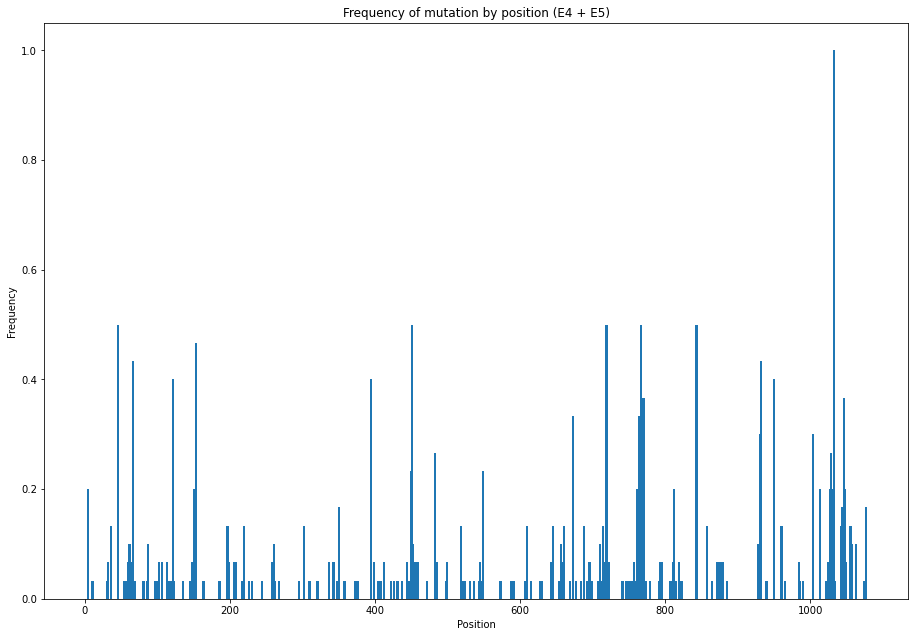

In [32]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0,0,1,1])
ax.bar(locations, counts, width=3)
plt.ylabel('Frequency')
plt.xlabel('Position')
plt.title('Frequency of mutation by position (E4 + E5)')
plt.show()

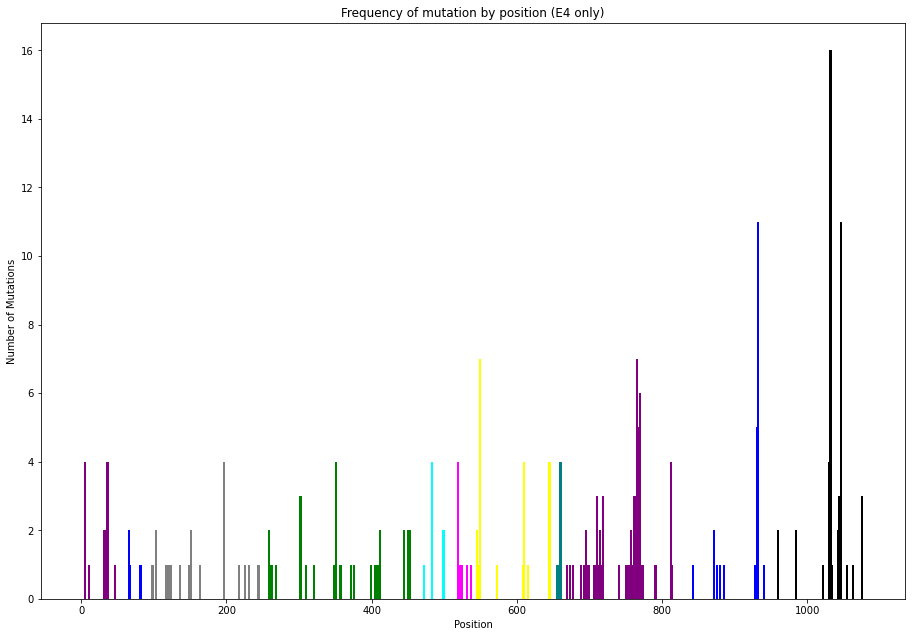

In [34]:
fig = plt.figure(figsize=(12,8))

# add color code for domains
ax = fig.add_axes([0,0,1,1])
ax.bar(locations, e4counts, width = 3, color=colors)
plt.ylabel('Number of Mutations')
plt.xlabel('Position')
plt.title('Frequency of mutation by position (E4 only)')
plt.show()


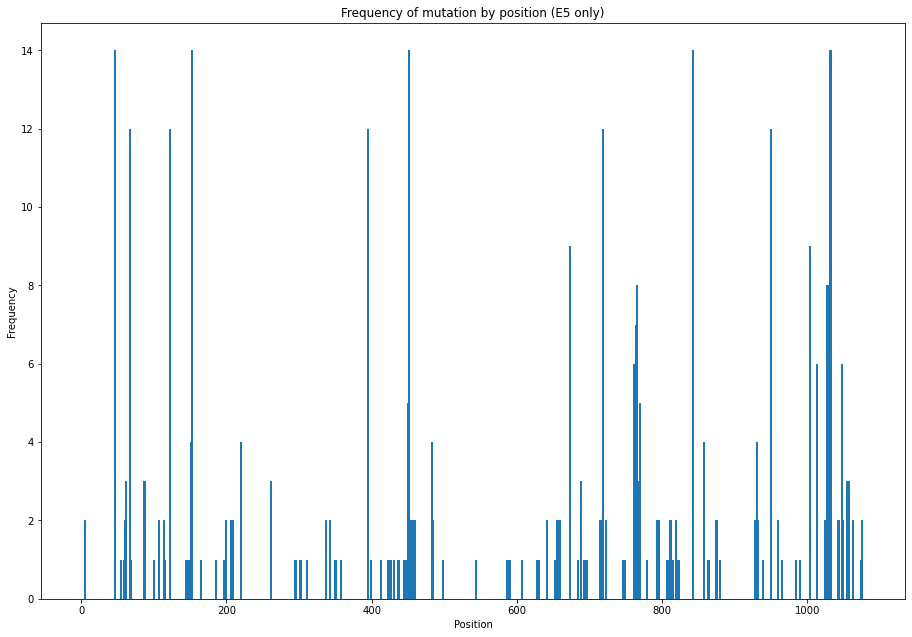

In [35]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0,0,1,1])
ax.bar(locations, e5counts, width = 3)
plt.ylabel('Frequency')
plt.xlabel('Position')
plt.title('Frequency of mutation by position (E5 only)')
plt.show()

### Mutual Exclusivity / Co-occurence Analysis
For each position (ignoring specific muations here for now)

| A           | B           | Neither     | A not B     | B not A     | Both            | Log2 Odds Ratio | p-value     | q-value     | tendency      |
| ----------- | ----------- | ----------- | ----------- | ----------- | -----------     | -----------     | ----------- | ----------- | --------------|
| p1          | p2          | count       | count       | count       | count           | odds ratio      | pv          | qv          | tendency      |

Log2 Odds Ratio: quantifies how strongly the presence or absence of alterations in A are associated with alterations in B
(Neither * Both) / (A not B * B not A). Haldane-Anscombe correction applied (add 0.5 to each value)

p-test: one-sided fisher exact
q value from Benjamini-Hochberg FDR Correction

Tendency: log2(OR) > 0: co-occurence. Log2(OR) <=0: mutual exclusivity. q-value < 0.05: significant

TODO: Look at the variant with highest activity. For the mutations in that, look at mutations in other samples with co-occurance/mutal exclusivitiy and compare activity levels. If activity levels high and co-occuring, likely important.

In [37]:
mutex_list = []
for i,location1 in enumerate(e4locations):    
    for j,location2 in enumerate(e4locations):
        mutex = {}
        if i <= j:
            continue
        mutex['a'] = location1
        mutex['b'] = location2
        # get the counts by iterating through the samples to see if they have mut at this location
        # Adding 0.5 for Haldane-Anscombe correction (deals with 0 values in the matrix)
        mutex['neither'] = 0.5
        mutex['anotb'] = 0.5
        mutex['bnota'] = 0.5
        mutex['both'] = 0.5
        
        a_count = 0
        b_count = 0
        no_a_count = 0
        no_b_count = 0
        
        for sample in e4mutations:
            a = False
            b = False
            
            if sample['mutations'][i] != '':
                a = True
                a_count += 1
            else:
                no_a_count += 1
            if sample['mutations'][j] != '':
                b = True
                b_count += 1
            else:
                no_b_count += 1        
                
            oddsratio, pvalue = scipy.stats.fisher_exact([[a_count, b_count],[no_a_count, no_b_count]])
            
            if a and not b:
                mutex['anotb'] = mutex['anotb'] + 1
            elif b and not a:
                mutex['bnota'] = mutex['bnota'] + 1
            elif a and b:
                mutex['both'] = mutex['both'] + 1
            else:
                mutex['neither'] = mutex['neither'] + 1
            
        mutex['log2'] = math.log2((mutex['neither'] * mutex['both']) / (mutex['anotb'] * mutex['bnota']))
        mutex['pval'] = pvalue
        mutex_list.append([mutex['a'], mutex['b'], str(mutex['neither'] - 0.5), str(mutex['anotb'] - 0.5), str(mutex['bnota']-0.5), str(mutex['both']-0.5), str(round(mutex['log2'],2)), str(round(pvalue, 5))])
        

In [38]:
e4muts = ['P6', 'E33', 'K104', 'D152', 'F260', 'A263', 'A303', 'D451', 'E520', 'R646', 'F696', 'G711', 'I758', 'H767', 'E932', 'N1031', 'R1033', 'K1044', 'Q1047', 'V1056']
to_list = []
pd.set_option('display.max_rows', None)
for mutex in mutex_list:
#    if (mutex[0] in e4muts or mutex[1] in e4muts) and float(mutex[7]) <= .05 and float(mutex[6]) < -3:
    if float(mutex[7]) <= .02 and float(mutex[6]) < -2:
        to_list.append(mutex)
#for l in to_list:
#    print(l)
pd.DataFrame(to_list, columns = ["Position A", "Position B", "Neither", "A not B", "B not A", "Both", "Odds Ratio", "p-Value"])

,Position A,Position B,Neither,A not B,B not A,Both,Odds Ratio,p-Value
0,S933,E47,4.0,11.0,1.0,0.0,-2.94,0.00064
1,S933,D98,4.0,11.0,1.0,0.0,-2.94,0.00064
2,S933,K104,3.0,11.0,2.0,0.0,-4.04,0.00319
3,S933,F260,3.0,11.0,2.0,0.0,-4.04,0.00319
4,S933,A263,4.0,11.0,1.0,0.0,-2.94,0.00064
5,S933,A303,2.0,11.0,3.0,0.0,-5.01,0.01134
6,S933,Y310,4.0,11.0,1.0,0.0,-2.94,0.00064
7,S933,N373,4.0,11.0,1.0,0.0,-2.94,0.00064
8,S933,D451,3.0,11.0,2.0,0.0,-4.04,0.00319
9,S933,R473,4.0,11.0,1.0,0.0,-2.94,0.00064


### Load editing data
MiSeq Data

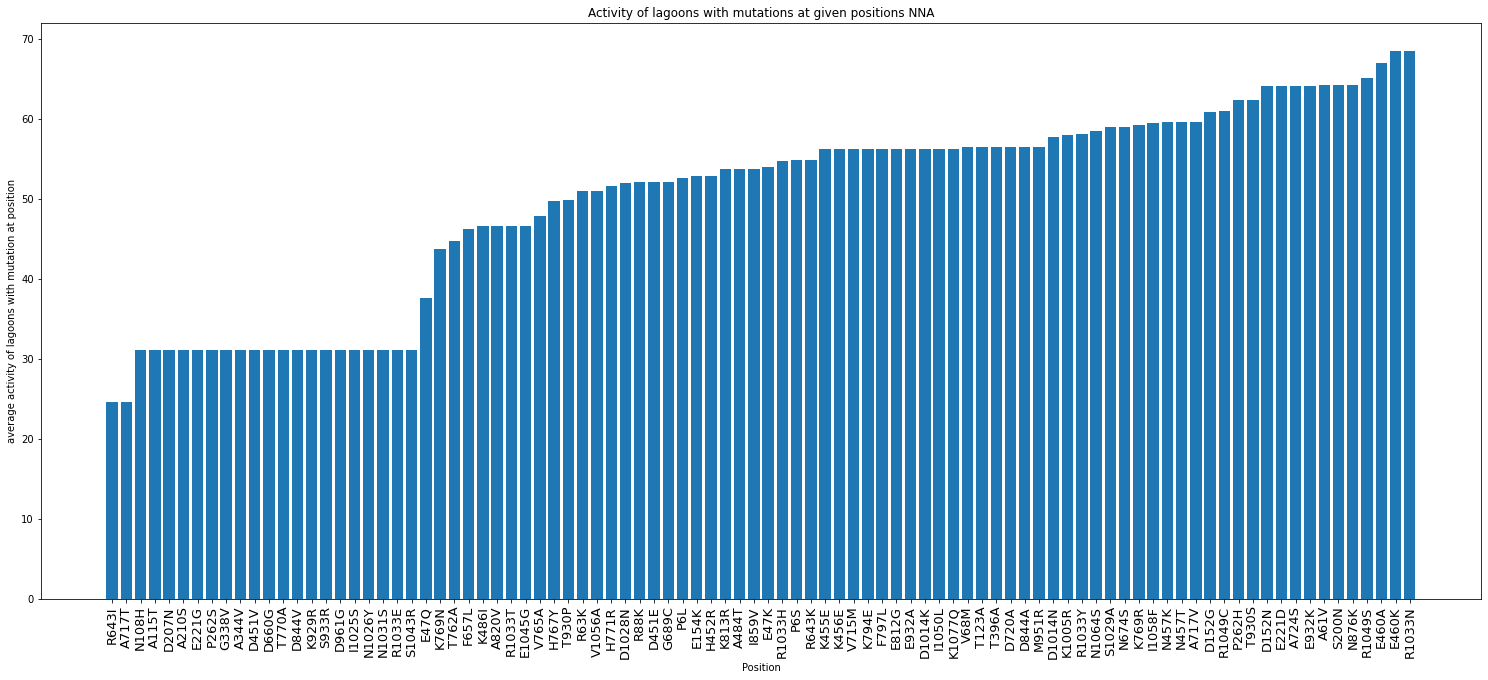

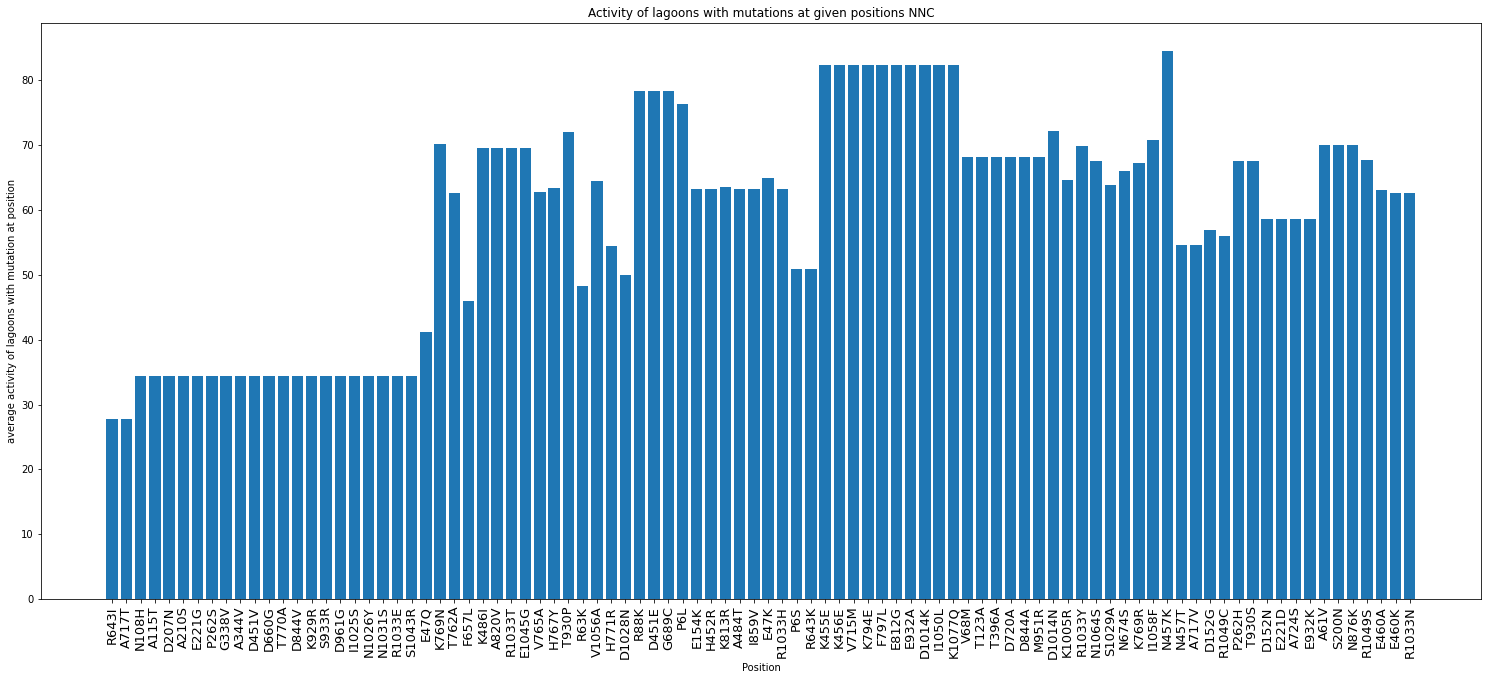

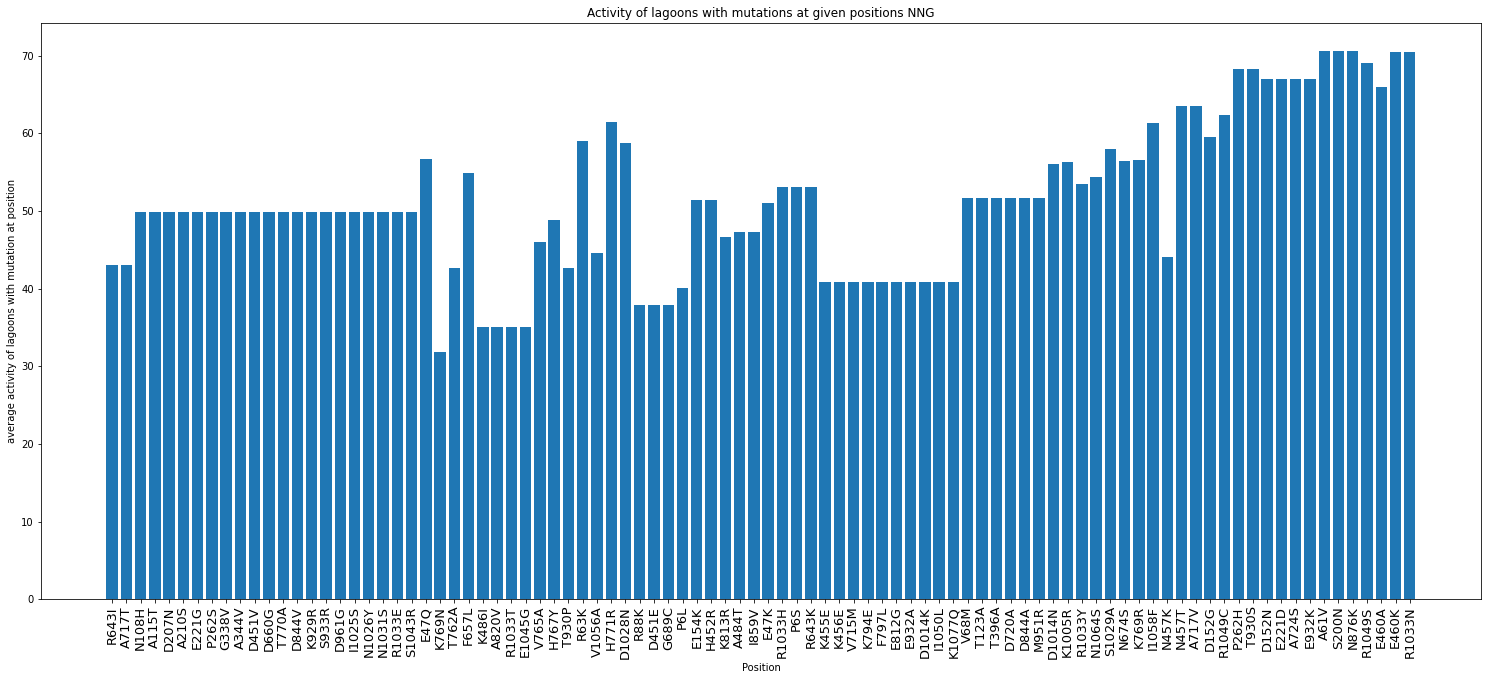

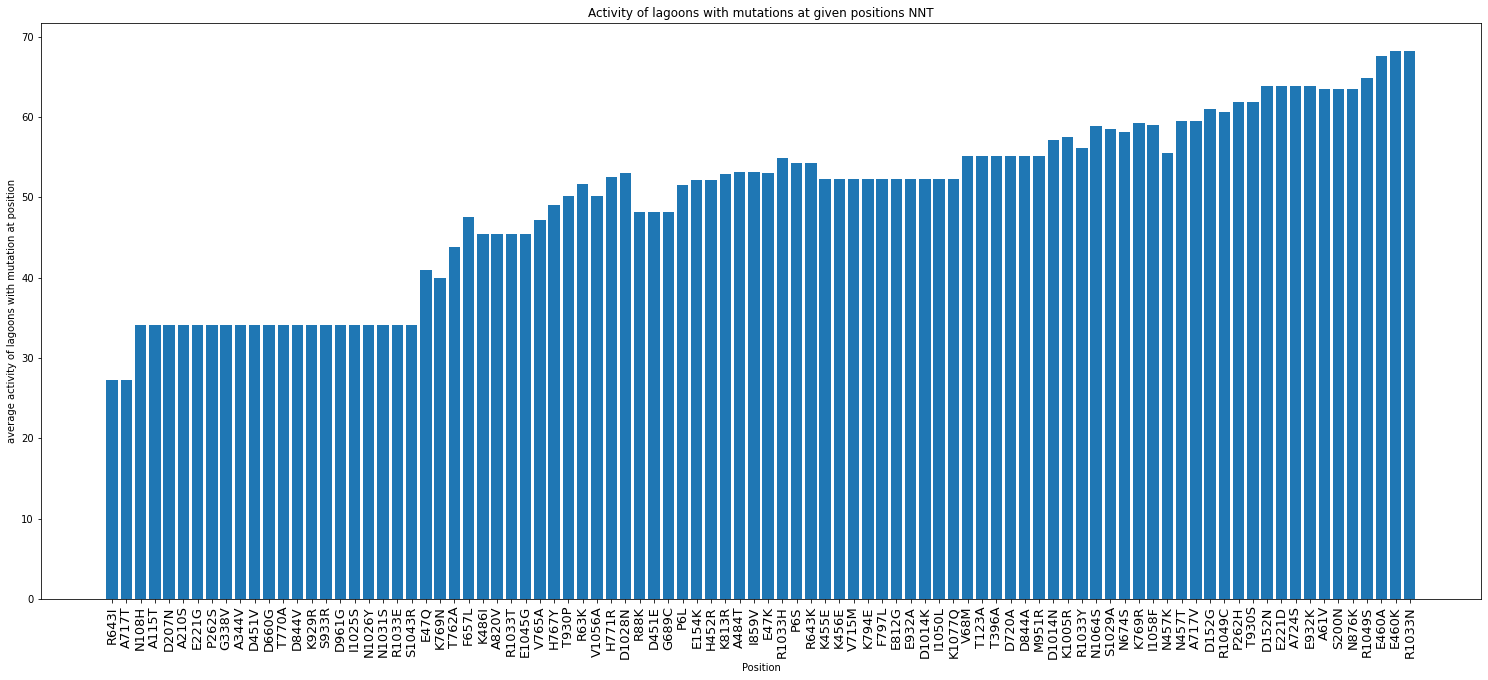

In [39]:
e4_pooled_all_7_positions_all_average = [19.4, 24.4,26.8, 40.9, 21.5, 26.3, 24.2, 22.6, 16.9, 23, 22.7, 21.3, 20, 18.6, 24.5, 23.3]
e4_pooled_all_7_positions_cpam_average = [64.48, 68.53, 68.59, 80.84, 68.01, 77.07, 70.91, 69.06, 53.15, 64.77, 71.02, 64.49, 56.33, 59.07, 61.66, 62.53]

e4_pooled_all_7_NCA = [73.74, 73.21, 68.75, 83.83, 70.44, 78.65, 73.69, 71.84, 46.49, 58.55, 74.98, 68.43, 63.57, 64.18, 66.99, 67.83];
e4_pooled_all_7_NCC = [66.61053243,69.49755142,69.95180207,80.4903751,71.95210255,80.5674104,73.92105949,74.429117,54.73933221,66.66920381,73.82650912,67.77429867,55.78605375,60.33931426,63.62912191,62.14925265];
e4_pooled_all_7_NCG = [56.55287791,63.27192605,70.9581768,78.57496302,61.87731455,70.69780974,64.75108786,60.7550885,61.15544185,73.41523203,65.13846724,58.93432484,52.0882119,54.39511595,57.73256788,61.33347971];
e4_pooled_all_7_NCT = [62.00788161,68.13080439,64.68944824,80.45063312,67.76559429,78.38102063,71.2837539,69.21367084,49.81703005,60.46215528,70.1309541,62.80081794,53.87129792,57.35949054,58.28577853,58.82172111];

e4_pooled_all_7_NAN = [7.4523,14.4409,18.0626,35.8614,10.3150,15.6185,14.1783,11.4205,8.1421,13.8988,11.0546,11.8430,11.5479,8.4213,18.6789,16.5240]
e4_pooled_all_7_NCN = [64.4777,68.5280,68.5878,80.8372,68.0083,77.0745,70.9115,69.0617,53.1533,64.7745,71.0181,64.4854,56.3296,59.0675,61.6599,62.5325]
e4_pooled_all_7_NGN = [2.3716,6.4856,11.2507,21.6210,3.1141,5.5312,4.8325,3.9880,3.9494,8.1158,3.5239,3.8291,6.7732,2.8810,8.9444,7.1171]
e4_pooled_all_7_NTN = [3.1748,7.9689,9.2492,25.1456,4.4795,6.8398,6.7655,5.9716,2.5258,5.3864,5.3975,4.9487,5.3465,3.9032,8.7444,7.0196]

e5_poled_all_7_all = [65.92,14.09,44.12,30.65,69.23,65.01,54.97,60.94,46.45,43.21,46.16,55.15,49.66,53.25,67.46,53.72,59.31]
e5_poled_all_7_tpam = [75.02,16.60,39.03,25.16,73.46,68.98,64.74,69.88,54.34,47.22,50.72,61.52,56.15,62.46,74.19,62.48,67.16]

e5_poled_all_7_NTA = [74.87852908,15.25212911,36.96283386,22.52329024,69.375605,66.00801628,62.41386083,68.95271462,49.79998762,44.166857,48.2120514,58.93802954,49.74323956,61.83875159,74.1842161,59.76101072,67.31782779]
e5_poled_all_7_NTC = [73.96951883,22.33873769,32.96501141,19.95899175,77.27669471,71.67083648,87.21908271,88.95441287,77.75242105,67.4399637,71.00563257,82.1109943,62.55560811,60.90708145,70.17189336,78.6549213,62.35564776]
e5_poled_all_7_NTG = [75.87832094,13.48640813,56.60132466,41.93045133,77.18208193,71.93333644,48.92122886,55.07598677,40.63892455,33.18595698,36.28242646,46.3440386,60.71490295,63.95220284,78.16375391,52.68676198,72.11253139]
e5_poled_all_7_NTT = [75.34861761,15.33550616,29.58848532,16.21934849,69.98939396,66.31009838,60.39407802,66.55384095,49.15344201,44.08081596,47.39059408,58.70018526,51.5904855,63.12857217,74.23081007,58.82158882,66.87181211]

e5_poled_all_7_NAN = [62.60,12.19,44.95,30.79,64.12,60.71,48.24,54.18,41.06,35.95,39.58,46.86,43.45,50.02,66.01,47.73,56.78]
e5_poled_all_7_NCN = [63.30,15.55,39.81,27.19,71.32,67.05,60.48,66.84,53.53,57.22,58.52,67.95,52.72,49.34,61.42,57.96,55.55]
e5_poled_all_7_NGN = [62.76,12.00,52.69,39.48,68.03,63.29,46.41,52.87,36.89,32.46,35.82,44.26,46.32,51.17,68.25,46.69,57.77]
e5_poled_all_7_NTN = [75.02,16.60,39.03,25.16,73.46,68.98,64.74,69.88,54.34,47.22,50.72,61.52,56.15,62.46,74.19,62.48,67.16]

e5_ANA = [62.11,11.11,33.87,21.61,60.35,57.43,49.13,55.64,41.70,39.33,41.45,50.29,39.43,50.96,63.89,44.52,53.74]
e5_CNA = [70.03,13.89,36.29,21.18,70.71,65.09,55.84,62.70,45.38,41.88,44.33,53.15,48.23,57.54,70.73,52.87,62.47]
e5_GNA = [60.91,10.35,34.35,23.08,58.67,57.38,45.37,53.10,38.34,33.71,37.42,45.09,38.03,48.67,65.15,43.64,54.81]
e5_TNA = [74.96,15.91,46.17,32.67,75.13,69.70,61.00,67.03,49.82,48.25,51.48,61.92,55.14,62.28,74.49,58.78,67.66]
e5_ANC = [58.47,19.32,36.00,24.21,68.27,64.08,77.96,82.78,66.90,60.93,63.93,75.60,47.84,46.51,59.48,69.02,50.29]
e5_CNC = [65.73,22.09,41.93,26.96,75.29,69.31,86.04,88.47,75.45,66.34,69.66,80.32,56.99,53.50,64.40,76.93,56.18]
e5_GNC = [58.38,17.84,36.56,22.59,69.06,64.44,73.63,78.95,62.34,53.79,56.80,67.60,50.06,45.49,58.77,64.93,50.93]
e5_TNC = [69.85,21.52,50.16,37.09,77.86,72.04,83.38,88.04,76.14,69.43,70.30,81.94,63.28,57.80,67.67,77.21,60.81]
e5_ANG = [61.97,9.13,51.75,39.28,68.28,65.05,34.25,40.67,29.27,29.17,33.03,39.03,48.56,50.35,67.37,37.76,60.45]
e5_CNG = [68.19,11.31,57.09,42.56,76.68,70.82,39.91,45.50,33.03,30.16,33.27,40.38,57.70,54.38,70.92,43.97,65.02]
e5_GNG = [61.68,8.92,52.81,37.40,68.02,63.89,32.19,38.83,26.79,25.24,27.41,33.96,46.86,46.97,68.05,37.11,59.28]
e5_TNG = [71.98,13.24,65.08,52.95,79.00,73.57,44.54,51.25,38.13,35.18,38.83,47.18,63.29,60.52,75.47,51.94,69.25]
e5_ANT = [63.77,11.10,34.95,22.40,60.12,57.90,43.51,50.06,35.74,37.19,41.14,48.44,39.51,50.96,64.90,44.27,54.58]
e5_CNT = [69.89,13.69,41.17,25.98,67.57,63.95,51.90,58.57,42.45,39.79,43.02,51.92,47.62,55.67,68.86,53.99,61.14]
e5_GNT = [65.47,11.02,34.72,21.20,61.10,58.47,46.34,52.26,36.77,35.68,38.61,47.57,38.93,50.23,67.57,45.24,57.17]
e5_TNT = [71.37,14.93,53.06,39.29,71.60,67.02,54.46,61.26,45.02,45.34,47.87,58.00,53.10,60.13,71.70,57.28,65.23]

e5_NNA = [67.00,37.67,24.64,66.21,62.40,52.84,59.62,43.81,40.79,52.61,54.86,68.57,49.95,59.67];
e5_NNC = [63.11,41.16,27.71,72.62,67.47,80.25,84.56,70.21,62.62,76.36,50.83,62.58,72.02,54.55];
e5_NNG = [65.96,56.68,43.05,72.99,68.33,37.72,44.06,31.81,29.94,40.14,53.05,70.46,42.69,63.50];
e5_NNT = [67.63,40.98,27.22,65.10,61.83,49.05,55.54,39.99,39.50,51.48,54.25,68.26,50.19,59.53];

e5_names = [1, 13, 17, 11, 12, 22, 24, 19, 28, 26, 34, 40, 5, 36]

e4_NNA = [20.87,23.23,26.23,40.31,20.51,24.18,22.32,20.88,13.27,18.31,21.79,20.44,21.77,18.94,25.62,24.55]
e4_NNC = [22.91,33.14,29.16,49.86,27.53,34.78,32.90,31.20,17.78,25.25,29.45,27.70,24.30,22.79,29.17,26.69]
e4_NNG = [16.21,19.81,28.24,36.05,18.03,21.94,19.49,17.90,22.19,29.25,18.99,17.82,16.16,16.00,21.39,21.33]
e4_NNT = [17.49,21.24,23.51,37.24,19.84,24.16,21.97,20.46,14.53,19.36,20.77,19.14,17.76,16.54,21.85,20.62]

#datas = [e4_pooled_all_7_positions_all_average, e4_pooled_all_7_positions_cpam_average, e4_pooled_all_7_NCA, e4_pooled_all_7_NCC, e4_pooled_all_7_NCG,e4_pooled_all_7_NCT, e4_pooled_all_7_NAN, e4_pooled_all_7_NCN, e4_pooled_all_7_NGN, e4_pooled_all_7_NTN]

#names = ['All-e4', 'All C-PAM-e4', 'NCA', 'NCC', 'NCG', 'NCT', 'NAN', 'NCN', 'NGN', 'NTN']

#datas = [e5_poled_all_7_all, e5_poled_all_7_tpam, e5_poled_all_7_NTA, e5_poled_all_7_NTC, e5_poled_all_7_NTG, e5_poled_all_7_NTT, e5_poled_all_7_NAN, e5_poled_all_7_NCN, e5_poled_all_7_NGN, e5_poled_all_7_NTN]
#names = ['All-e5', 'All T-PAM-e5', 'NTA', 'NTC', 'NTG', 'NTT', 'NAN', 'NCN', 'NGN', 'NTN']

#datas = [e5_ANA, e5_CNA, e5_GNA, e5_TNA, e5_ANC, e5_CNC, e5_GNC, e5_TNC, e5_ANG, e5_CNG, e5_GNG, e5_TNG, e5_ANT, e5_CNT, e5_GNT, e5_TNT]
#names = ['ANA', 'CNA','GNA', 'TNA', 'ANC', 'CNC', 'GNC', 'TNC', 'ANG', 'CNG', 'GNG', 'TNG', 'ANT', 'CNT', 'GNT', 'TNT']

datas = [e5_NNA, e5_NNC, e5_NNG, e5_NNT]
names = ['NNA', 'NNC', 'NNG', 'NNT']

#datas = [e4_NNA, e4_NNC, e4_NNG, e4_NNT]
#names = ['NNA', 'NNC', 'NNG', 'NNT']

all_datas_zipped = zip(datas, names)

# e4locations, e4mutations
position_map = {}
first = True
locs_all = []
vs_all = []
for datas, name in all_datas_zipped:
    max_activity = 0
    locations_to_plot = []
    location_activity_data = {}
    for i,location in enumerate(e5locations):
        activity_average = {}
        mutcount = {}
        mutcount_total = 0
        for sample in e5mutations:
            #print(sample['id'])
            id = int(sample['id'].split('-')[-1])
            #id = int(sample['id'])
            activity = datas[e5_names.index(int(id))]
            if sample['mutations'][i] != '':
                if sample['mutations'][i] not in activity_average:
                    activity_average[sample['mutations'][i]] = 0
                    mutcount[sample['mutations'][i]] = 0
                activity_average[sample['mutations'][i]] += activity
                mutcount_total += 1
                mutcount[sample['mutations'][i]] += 1
        for aa, activity in activity_average.items():
            try:
                activity_average[aa] = activity_average[aa] / mutcount[aa]
                if activity_average[aa] > max_activity:
                    max_activity = activity_average[aa]
            except ZeroDivisionError:
                activity_average[aa] = 0
            if mutcount_total > 1:
                location_activity_data[location + aa] = activity_average[aa]
    if first:
        a = sorted(location_activity_data.items(), key = lambda x: x[1])
        for i,v in enumerate(a):
            position_map[v[0]] = i
            
    else:
        # use map
        a = [('', 0)] * len(position_map.keys())
        for k, v in location_activity_data.items():
            a[position_map[k]] = (k, v)
            
    locs = []
    vs = []

    for l,v in a:
        if v > 0:
            locs.append(l)
            #vs.append(v/max_activity)
            vs.append(v)
    locs_all.append(locs)
    vs_all.append(vs)

    fig = plt.figure(figsize=(20,8))

    ax = fig.add_axes([0,0,1,1])
    ax.bar(locs, vs)
    plt.ylabel('average activity of lagoons with mutation at position')
    plt.xlabel('Position')
    plt.title('Activity of lagoons with mutations at given positions ' + name)
    plt.xticks(rotation=90,fontsize=13)
    plt.xticks
    plt.show()
    fig.savefig('activity_by_mutations_' + name + '.svg', bbox_inches='tight')
    first = False

with open('heatmap_data.txt', 'w') as f:
    f.write('\t'.join(locs_all[0]) + '\n')
    for vs in vs_all:
        f.write('\t'.join(list(map(str, vs))) + '\n')